In [13]:
import numpy as np
from matplotlib import pyplot as plt
from model import USV
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
import seaborn as sns
import matplotlib.animation as animation

final_path = np.load("data/path_dronelab.npy")
final_path*=15


initial_positions = [(final_path[0][0], final_path[0][1], final_path[0][2])]
final_path = final_path[:,:2]

env = USV(
    v=0,
    dt=0.2,
    path_index=0,
    goal=final_path[-1],
    budget=20,
    initial_positions=initial_positions,
    final_paths=[final_path],
)

model = DQN.load("trained_models/dqn_communication_optimization_epsfrac08_steps300k_turtlebot_path_budget20_dronelab")

obs, _ = env.reset()
done = False
total_rewards = 0
ep_var = []
errors = []
traj_errors = [np.linalg.norm([env.car.x_true, env.car.y_true] - final_path[env.path_index])]
print("-------")
communicate_indices = []
variances = []
car_positions = [[env.car.x_true, env.car.y_true]]
observations = [np.array([env.car.x, env.car.y, env.car.v, env.car.psi, env.available_budget], dtype=np.float32)]
waypoint_deviations = 0
while not done:
    if np.linalg.norm([env.car.x, env.car.y] - final_path[env.path_index]) > 0.2*15:
        waypoint_deviations += 1
    if env.path_index <= 20:
        action = 0
    else:
        
        action, _states = model.predict(
            obs[:5], deterministic=True
        )  # Use the model to predict the action
    if action == 1:
        communicate_indices.append(env.path_index)

    traj_errors.append(np.linalg.norm([env.car.x_true, env.car.y_true] - final_path[env.path_index]))
    errors.append(
        np.linalg.norm(
            np.array([env.car.x, env.car.y]) - np.array([env.car.x_true, env.car.y_true])
        ))
    variances.append(np.linalg.norm(env.car.pf_var))
    obs, rewards, terminated, truncated, info = env.step_test(
        action
    )  # Take the action in the environment
    observations.append(obs[:5])
    car_positions.append([env.car.x_true, env.car.y_true])
    total_rewards += rewards
    done = truncated or terminated

/Users/cockroach/miniconda3/envs/clean_env/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/Users/cockroach/miniconda3/envs/clean_env/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


-------


19


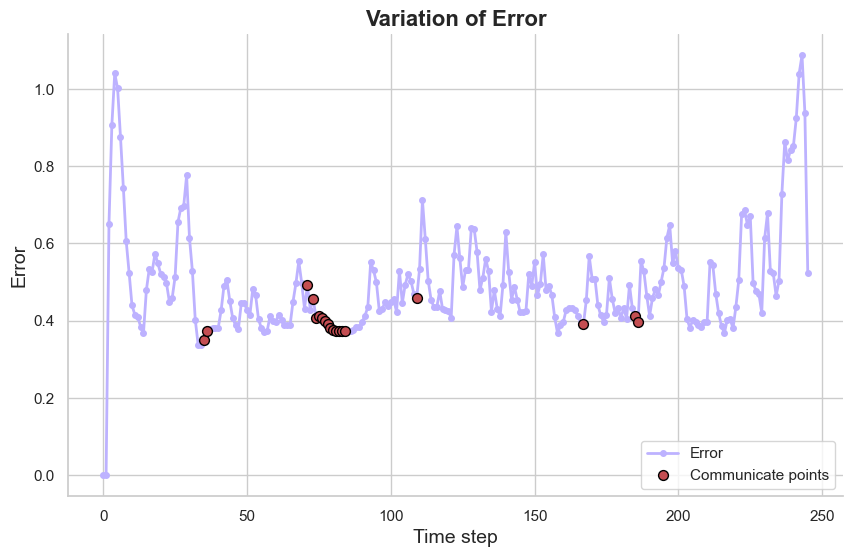

In [14]:
print(len(communicate_indices))
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(traj_errors, label="Error", linestyle='-', marker='o', markersize=4, linewidth=2, color='#BDB2FF')
plt.scatter(communicate_indices, [traj_errors[i] for i in communicate_indices], c='r', label="Communicate points", s=50, edgecolor='black', zorder=5)
plt.title("Variation of Error", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.legend()
sns.despine()
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

line, = ax.plot([], [], label="Error", linestyle='-', marker='o', markersize=4, linewidth=2, color='#BDB2FF')
scatter = ax.scatter([], [], c='r', label="Communicate points", s=50, edgecolor='black', zorder=5)

ax.set_title("Variation of Error", fontsize=16, fontweight='bold')
ax.set_xlabel("Time step", fontsize=14)
ax.set_ylabel("Error", fontsize=14)
ax.legend()

ax.set_xlim(0, len(traj_errors))
ax.set_ylim(0, max(traj_errors) * 1.1)

def update(frame):
    line.set_data(range(frame), traj_errors[:frame])
    
    comm_indices = [i for i in communicate_indices if i < frame]
    comm_errors = [traj_errors[i] for i in comm_indices]
    scatter.set_offsets(np.c_[comm_indices, comm_errors])
    
    return line, scatter

anim = animation.FuncAnimation(fig, update, frames=len(traj_errors), interval=20000/len(traj_errors), blit=True)

anim.save('trajectory_error_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.close(fig)  

print("Animation saved as 'trajectory_error_animation.mp4'")

Animation saved as 'trajectory_error_animation.mp4'


In [29]:
print(f'Communication indices: {communicate_indices}')

Communication indices: [69, 72, 73, 75, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 119, 173, 191, 192]


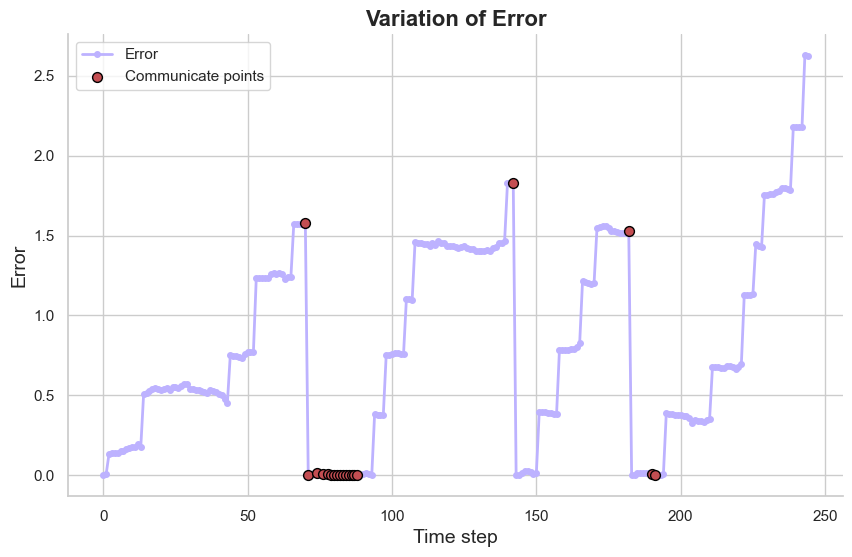

In [5]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(errors, label="Error", linestyle='-', marker='o', markersize=4, linewidth=2, color='#BDB2FF')
plt.scatter(communicate_indices, [errors[i] for i in communicate_indices], c='r', label="Communicate points", s=50, edgecolor='black', zorder=5)
plt.title("Variation of Error", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.legend()
sns.despine()
plt.show()

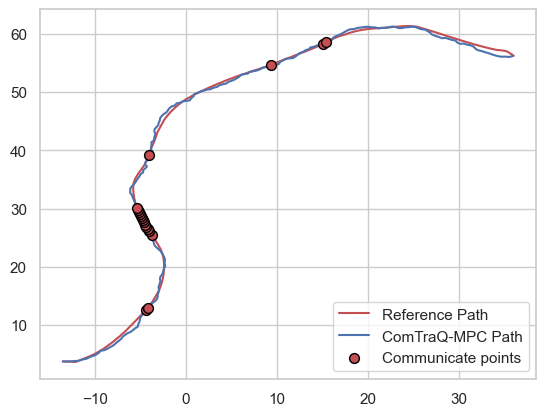

In [15]:
plt.plot(final_path[:, 0], final_path[:, 1], "r", label="Reference Path")
plt.plot(np.array(car_positions)[:, 0], np.array(car_positions)[:, 1], "b", label="ComTraQ-MPC Path")
plt.scatter(final_path[communicate_indices, 0], final_path[communicate_indices, 1], c='r', label="Communicate points", s=50, edgecolor='black', zorder=5)
plt.legend()
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(final_path[:, 0], final_path[:, 1], "r", label="Reference Path")

car_path, = ax.plot([], [], "b", label="ComTraQ-MPC Path")

comm_scatter = ax.scatter([], [], c='r', label="Communicate points", s=50, edgecolor='black', zorder=5)

ax.set_title("Car Path and Communication Points", fontsize=16, fontweight='bold')
ax.set_xlabel("X position", fontsize=14)
ax.set_ylabel("Y position", fontsize=14)
ax.legend()

ax.set_xlim(min(final_path[:, 0]) - 1, max(final_path[:, 0]) + 1)
ax.set_ylim(min(final_path[:, 1]) - 1, max(final_path[:, 1]) + 1)

def update(frame):
    car_path.set_data(np.array(car_positions)[:frame, 0], np.array(car_positions)[:frame, 1])
    
    comm_indices = [i for i in communicate_indices if i < frame]
    comm_points = np.array(car_positions)[comm_indices]
    comm_scatter.set_offsets(comm_points)
    
    return car_path, comm_scatter

anim.save('car_path_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.close(fig)  # Close the figure to prevent it from displaying in the notebook

print("Animation saved as 'car_path_animation.mp4'")

Animation saved as 'car_path_animation.mp4'
